<a href="https://colab.research.google.com/github/JA4S/JANC/blob/main/examples/1D/Ignition-Delay/0D_ignition_delay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install JANC and import relevant libraries

In [ ]:
!pip install git+https://github.com/JA4S/JANC.git
!wget https://raw.githubusercontent.com/JA4S/JANC/main/examples/1D/Ignition-delay/9sp-19r-H2-Air.yaml

In [ ]:
from janc_v2.model import thermo_model
from janc_v2.simulation import set_simulator

import cantera as ct
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# set JAX to use GPU
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'gpu')

# Example : 0D Ignition-delay

In [ ]:
#grid config
#this is essentially a 【0D】 simulation
Lx = 1.0
nx = 5
dx = Lx/nx
grid_config = {'dx':dx}

thermo_config = {'thermo_model':'nasa7',
         'mechanism_directory':'9sp-19r-H2-Air.yaml'
          }
thermo_model.set_thermo(thermo_config)
#reaction_config
reaction_config = {'is_detailed_chemistry':True,
           'mechanism_directory':'9sp-19r-H2-Air.yaml'
          }
#flux_config
flux_config = {'solver_type':'flux_splitting',
        'interface_reconstruction':'WENO5_JS',
        'split_method':'LF',
        'viscosity':'off'
        }
boundary_config = {'left_boundary':'periodic',
           'right_boundary':'periodic'}

In [ ]:
dt = 5e-9
t_end = 6e-6
time_control = {'temporal_evolution_scheme':'TVD_RK3',
         'dt':dt,
         't_end':t_end}
output_settings = {'save_dt':dt,
           'results_path':'results.h5'}
computation_config = {'output_settings':output_settings}
simulation_config = {'dimension':'1D',
            'grid_config':grid_config,
            'thermo_config':thermo_config,
            'reaction_config':reaction_config,
            'flux_config':flux_config,
            'boundary_config':boundary_config,
            'time_config':time_control,
            'computation_config':computation_config}
Simulator = set_simulator.Simulator(simulation_config)

In [ ]:
initial_temp = 1700
initial_pressure = 20 * ct.one_atm
def initial_conditions(P,T,EQ):
    yH2 = (EQ/8*0.232)/(1 + EQ/8*0.232)
    yO2 = 0.232/(1 + EQ/8*0.232)
    Y = jnp.tile(jnp.array([yH2,yO2,0.0,0.0,0.0,0.0,0.0,0.0])[:,None],(1,nx))
    T = jnp.full_like(Y[0:1],T)
    P = jnp.full_like(Y[0:1],P)
    _,gamma, h, R,_ = thermo_model.get_thermo(T,Y)

    rho_init = P/(R*T)
    rhou_init = jnp.zeros_like(rho_init)
    E_init = rho_init*h - P
    rhoY_init = rho_init*Y
    U_init = jnp.concatenate([rho_init,rhou_init,E_init,rhoY_init],axis=0)
    aux_init = jnp.concatenate([gamma,T],axis=0)
    return U_init, aux_init

Pi = initial_pressure
Ti = initial_temp
EQ = 1.0
U, aux = initial_conditions(Pi,Ti,EQ)

In [ ]:
U_final, aux_final, t_final = Simulator.run(U,aux)

Simulation: 100%|██████████| 6e-06/6e-06 [00:08<00:00]


# Postprocess

In [ ]:
t, state_dict = Simulator.saver.load_all()
t = 1000*t             #change to millisecond(ms)
T = state_dict['tempreature'][:,0] #T is uniformly distributed among grids, we only chose the results from the first grid

ignition_delay: 3.15e-04 ms


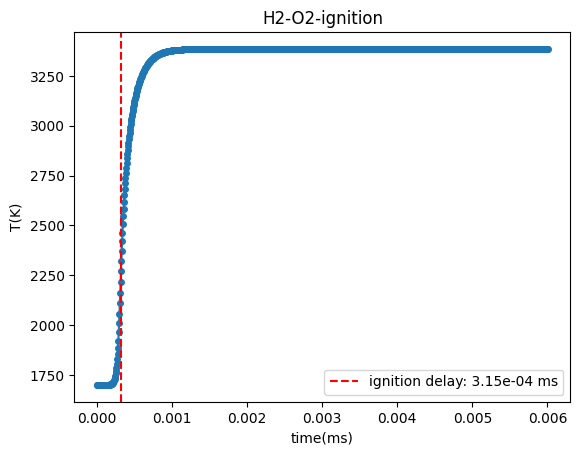

In [ ]:
#Using temporal derivatives of T to calculate ignition delay
dTdt = np.diff(T) / np.diff(t)
ignition_index = np.argmax(dTdt) + 1  #index for max derivative
ignition_delay = t[ignition_index]

print(f"ignition_delay: {ignition_delay:.2e} ms")

plt.figure()
plt.plot(t, T, '-o', markersize=4)
plt.xlabel('time(ms)')
plt.ylabel('T(K)')
plt.title('H2-O2-ignition')
plt.axvline(ignition_delay, color='red', linestyle='--', label=f'ignition delay: {ignition_delay:.2e} ms')
plt.legend()
plt.show()

Compare the results with Cantera

开始模拟...
ignition_delay: 3.39e-04 ms


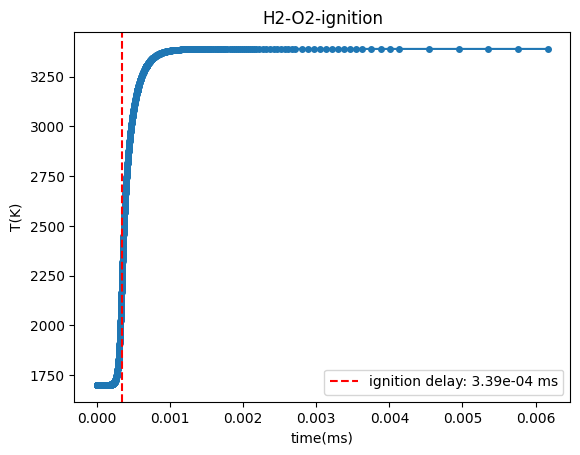

In [ ]:

#load the same reaction mechanism as JANC
gas = ct.Solution('9sp-19r-H2-Air.yaml')

#H2-Air mixture with equivalence ratio = 1.0
gas.set_equivalence_ratio(1.0, 'H2', {'O2': 1.0, 'N2': 3.76})

#same initial tempreature and pressure as JANC
gas.TP = initial_temp, initial_pressure


reactor = ct.IdealGasReactor(gas)
sim = ct.ReactorNet([reactor])


max_simulation_time = t_end
times = []
temperatures = []


while sim.time < max_simulation_time:
    time = sim.step()
    times.append(1000*sim.time)  #change to millisecond
    temperatures.append(reactor.T)


dTdt = np.diff(temperatures) / np.diff(times)
ignition_index = np.argmax(dTdt) + 1
ignition_delay = times[ignition_index]

print(f"ignition_delay: {ignition_delay:.2e} ms")

plt.figure()
plt.plot(times, temperatures, '-o', markersize=4)
plt.xlabel('time(ms)')
plt.ylabel('T(K)')
plt.title('H2-O2-ignition')
plt.axvline(ignition_delay, color='red', linestyle='--', label=f'ignition delay: {ignition_delay:.2e} ms')
plt.legend()
plt.show()